# OPS: Off-the-grid package made simple 🎻

This tutorial is intended to illustrate the functionalities provided by the off-the-grid package.

See below the progress of the project (yes, it's quite a long journey! 🐢):


| Section    | Description                                                                      |    Status |
|------------|----------------------------------------------------------------------------------|----------:|
| Dirac      | Reconstruct points from one image                                                |    Done 🟢 |
| Covariance | Reconstruct static points with fluctuating <br>luminosity from a stack of images |    Done 🟢 |
| Curves     | Reconstruct points from one image                                                | Ongoing 🚧 |
| Dynamic    | Reconstruct dynamic points in a <br>blind  inverse problem settings              |    None 🔴 |

Also note the following forthcoming improvements:
- clearer support of forward operator, discard the `obj` and replace it by a `Kernel` object
- implement other PSF kernels, such as Airy disk + Fourier support;
- implement non-square domain $\mathcal X$ such as a rectangle or even a submanifold;
- implement new SFW improvements.

## Presentation

OPS (*Off-the-grid Package made Simple*) revolves around the following objects:
- the set where the source lives $\mathcal X$ is stored in the object `Domain2D`
- Dirac measure are implemented with the object `Dirac2D` (or in case of older implementation with `Mesure2D`)
- in the case of simulated acquisition, one can store all the information in the object `Bruits2D`

Our implementation relies on PyTorch subroutines, hence we implemented a GPU support for the sake of parallelisation. As far as we are concerned, we think that the GPU chiefly makes sense for a great number of Dirac: it is useful mostly for the last step where one plot all the reconstructed spikes on a super-resolved grid. Thus most of our objects incorporate a `dev` parameter. 
We recommand to set `dev='cpu'` if one wants to stay out of trouble.


First, let us import the module

In [1]:
__saveFig__ = False
__saveVid__ = False
__savePickle__ = False


from skimage import io
import numpy as np
import torch
import pickle
import time

import matplotlib.pyplot as plt

import cudavenant

[Cudavenant] Using cuda device


**Remark 🚧:** as in PyTorch, one ought to  be aware of the `dev` settings mayhem. For instance, one should always check if he is plotting the CPU version of the Tensor, otherwise it will presumably raise an error.

In [2]:
np.random.seed(80)

# GPU acceleration if needed
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print("[Test] Using {} device".format(device))

[Test] Using cuda device


## 1. Off-the-grid Dirac reconstruction from one image

### Deconvolution with Sliding Frank-Wolfe

Let $\Phi : \mathcal{M(X)} \to \mathcal H$ be the forward operator, $\mathcal H$ be the Hilbert space of acquisitions, typically $\mathcal H = \mathrm L ^2(\mathcal X)$ or an image $\mathcal H = \mathbb R ^L$ where $L$ is the number of pixels.
Let us introduce the functional BLASSO, standing for *Beurling-LASSO*:

$$ \mathrm{argmin}_{m \in \mathcal{M(X)}} || y - \Phi m ||_\mathcal{H}^2 + \lambda ||m||_{\mathrm{TV}} \quad\quad\quad (\mathcal{P}_\lambda(y))$$ 

One can tackle it by Sliding Frank-Wolfe.

Generate the domain $\mathcal X$ settings, here $\mathcal X = [0,1]^2$.

In [3]:
N_ECH = 64 # Number of pixels along x or y dimension
X_GAUCHE = 0 # left bound
X_DROIT = 1 # Right bound
SIGMA = 1e-1 # σ of the PSF of the system

# All these informations are stored in the domain object.
# Following the PyTorch paradigm, we transfer the object either to the CPU or the GPU
domain = cudavenant.Domain2D(X_GAUCHE, X_DROIT, N_ECH, SIGMA, dev=device)
domain_cpu = cudavenant.Domain2D(X_GAUCHE, X_DROIT, N_ECH, SIGMA)

For the purpose of super-resolution, we initialise a domain with a higher number of pixels. Note that the off-the-grid framework offers the ability to plot the reconstruction on **any grid of your choice without recomputing the reconstruction**, super-resolved or even non uniform grid (the latter being not implemented at this point).

In [4]:
q = 2**3 # super-resolution factor
super_domain = domain.super_resolve(q, SIGMA/4) # create a super-resolved domain i.e. a domain with more pixels 

Consider the source measure $m_{a_0,x_0} = \sum_{i=1}^N a_i \delta_{x_i}$ and the acquisition $y = \Phi m + w$ :

In [5]:
atom_number = 7 # number of spikes N
m_ax0 = cudavenant.mesure_aleatoire(atom_number, domain) # randomly initialise the source measure
y = m_ax0.kernel(domain) # generate the acquisition y = Φ(m)
y_cpu = y.to('cpu') # transfer the Tensor to GPU for plotting purposes

Plotting $y$: **be careful to plot the CPU version and not the GPU output!**

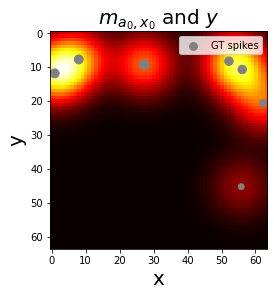

In [6]:
plt.imshow(y_cpu, cmap='hot')
plt.scatter((domain.N_ech-1)*m_ax0.x[:, 1], (domain.N_ech-1)*m_ax0.x[:, 0], marker='o',
            s=m_ax0.a*domain.N_ech, c='gray', label='GT spikes')
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.title('$m_{a_0, x_0}$ and $y$', fontsize=20)
plt.legend()
plt.show()

We are now solving the inverse problem through the BLASSO minimisation, performed by the state-of-the-art Sliding Frank Wolfe.

In [7]:
lambda_regul = 9e-5 # Relaxation parameter
iteration = atom_number

(m_sfw, nrj_sfw, mes_sfw) = cudavenant.SFW(y, domain, regul=lambda_regul, nIter=iteration,
                                           mesParIter=True, printInline=False, obj='acquis')

print(f"We recovered {m_sfw.N} δ-peaks out of {m_ax0.N}")

certificate_sfw = cudavenant.etak(m_sfw, y, domain, lambda_regul, obj='acquis')
certificate_sfw_cpu = certificate_sfw.to('cpu')

We recovered 7 δ-peaks out of 7


One can now compute the associated certificate $\eta_\lambda$ of the reconstructed measure $m_\mathrm{sfw}$. Finally, plot the results.

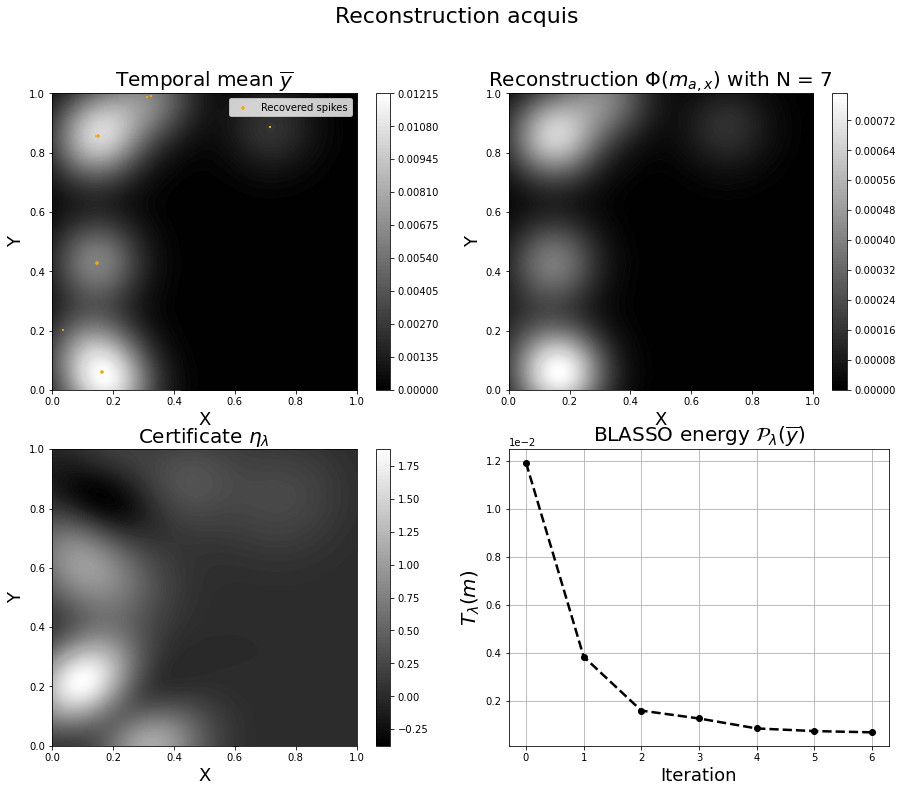

In [8]:
m_sfw_cpu = m_sfw.to('cpu') # always remember to convert your measure if needed!
nrj_sfw_cpu = nrj_sfw.to('cpu')
cudavenant.plot_experimental(m_sfw_cpu, domain_cpu, y_cpu, nrj_sfw_cpu, certificate_sfw_cpu, obj='acquis')

# To produce a gif of the iterated reconstruction
if __saveVid__ == True and m_sfw.a.size > 0:
    cudavenant.gif_results(y, m_ax0, m_sfw)

Eventually, one can compute the discrepancies between the reconstructed and the ground-truth measure by the *Flat metric*, a generalisation of the 1-Wasserstein distance $\mathcal{W}_1$. For more insights on this detection metric, see [Denoyelle2021 and al](https://arxiv.org/abs/2010.13423).

In [9]:
wasser_discrepancies = cudavenant.wasserstein_metric(m_sfw_cpu, m_ax0)
print(f"W_1(m_reconstructed, m_ax0) = {wasser_discrepancies:e}")

W_1(m_reconstructed, m_ax0) = 5.491664e-02


Let's talk about the other method

### Deconvolution with Conic Particle Gradient Descent

As in the latter section, let us set $\mathcal X$, create the source $m_{a_0,x_0}$, the noiseless acquisition $y_0 = \Phi m_{a_0,x_0}$ and the noisy one $y = y_0 + w + b$ where $w$ is Gaussian noise and $b$ is background noise.

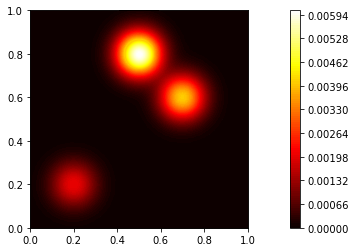

In [10]:
N_ECH = 2**7
X_GAUCHE = 0
X_DROIT = 1
SIGMA = 0.07

domain = cudavenant.Domain2D(X_GAUCHE, X_DROIT, N_ECH, SIGMA, dev=device)
domain_cpu = domain.to('cpu')
domain = domain.to(device)

amp = torch.tensor([1, 2, 3])
xpos = torch.tensor([[0.2, 0.2], [0.7, 0.6], [0.5, 0.8]])
m_ax0 = cudavenant.Mesure2D(amp, xpos)

y0 = m_ax0.kernel(domain)
y0_cpu = y0.to('cpu')
bru = cudavenant.Bruits(0, 1e-5, 'unif')

y = m_ax0.acquisition(domain, N_ECH, bru)
y_cpu = y.to('cpu')

plt.figure()
cont = plt.contourf(domain_cpu.X, domain_cpu.Y, y_cpu, 100, cmap='hot')
for c in cont.collections:
    c.set_edgecolor("face")
plt.colorbar()
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

Let us now solve the BLASSO with the CPGD (*Conic Particle Gradient Descent*) from [Chizat2021](https://link.springer.com/article/10.1007/s10107-021-01636-z). $\alpha$, $\beta$ are regularisation parameters for the flow and $\lambda$ is still the penalisation in the BLASSO. Note that particles are uniformly disposed on the domain, and we initiliase `nParticles**2` of them through the paramater `nParticles`.

In [11]:
𝜈, 𝜈_itere, r_itere, θ_itere, nrj = cudavenant.CPGD(y, domain, λ=1e0, α=4e-2, 
                                                    β=1e1, nIter=250, 
                                                    nParticles=8, 
                                                    noyau='gaussien', 
                                                    obj='acquis')

[+] Computing CPGD on cuda: 100%|████████████████████████████████████████████████████| 250/250 [00:24<00:00, 10.12it/s]


We can then plot the results. First, show the limit of the gradient flow denoted $\nu_\infty$.

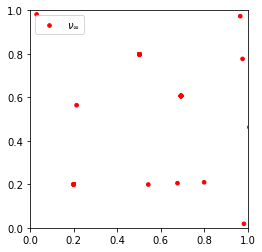

In [12]:
plt.figure()
plt.scatter(𝜈.x[:, 0], 𝜈.x[:, 1], label=r'$\nu_\infty$', marker='o',
            c='red', s=𝜈.a*domain_cpu.N_ech*5e7)
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.show()

The clusters of Dirac indicates the presence of an underlying source Dirac hidden in the data. 
Let us now plot the gradient flow $\nu_t$, so in a sense all the paths taken by the Diracs constituting the gradient flow.

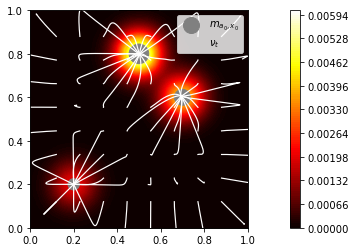

In [13]:
plt.figure()

# Plot the acquisition
cont = plt.contourf(domain_cpu.X, domain_cpu.Y, y_cpu, 100, cmap='hot')
for c in cont.collections:
    c.set_edgecolor("face")
plt.colorbar()
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])

# Plot the source measure
plt.scatter(m_ax0.x[:, 0], m_ax0.x[:, 1], label='$m_{a_0,x_0}$', marker='o',
            c='gray', s=m_ax0.a*domain_cpu.N_ech)

# Plot the gradient flow
for l in range(len(𝜈.a)):
    plt.plot(θ_itere[:, l, 0], θ_itere[:, l, 1], 'white', linewidth=1.2)
plt.scatter(𝜈.x[:, 0], 𝜈.x[:, 1], label='$\\nu_t$', c='white',
            s=𝜈.a*domain_cpu.N_ech)

plt.legend(loc=1)
plt.show()

Eventually, one can show the ouput gradient flow through `cudavenant.cpgd_anim(y_cpu, m_ax0, 𝜈_itere, θ_itere, domain_cpu, 'mp4').
`

## 2. Off-the-grid Dirac reconstruction from the covariance

The following is an illustration of the paper [Laville2022 and al.](https://doi.org/10.1109/ICASSP43922.2022.9746845).

Let $\mu : t \mapsto \sum_{i=1}^N a_i(t) \delta_{x_i}$ be the dynamic measure with fluctuating amplitudes. Note that **the positions are fixed**. In this part $y : [0,T] \to \mathrm{L}^2(\mathcal{X})$ is a dynamic acquisition (loosely speaking a stack of images) defined through $y(t) = \Phi \mu (t)$ for $t$ a.e.

Let $\overline{y} = \int_0^T y(\cdot, t) \, \mathrm d t$ be the temporal mean. Let $R_y \in \mathrm{L}^2(\mathcal{X}^2)$ be temporal covariance, defined through $\forall u, v \in \mathcal X$:

$$R_y(u,v) = \int_0^T (y(u,t) - \overline{y}(u)) (y(v,t) - \overline{y}(v)) \, \mathrm d t.$$

Let us denote $\Lambda(m) (u,v) = \int_{\mathcal X} h(x - u) h(x - v) \, \mathrm d m$ the so-called operator of covariance. Then for $m_{M,x} = \sum_{i=1}^N \mathrm{Var}(a_i) \delta_{x_i}$ and $\mathrm{Var}(a_i)$ is the temporal variance of the luminosity $a_i$, one has:

$$R_y = \Lambda m_{M,x}.$$

Hence one can reconstruct through BLASSO w.r.t $R_y$ a measure $m_{M,x}$ sharing the same position as $\mu$.

Let us introduce:

$$ \mathrm{argmin}_{m \in \mathcal{M(X)}} || R_y - \Lambda m ||_\mathcal{H^2}^2 + \lambda ||m||_{\mathrm{TV}} \quad\quad\quad (\mathcal{Q}_\lambda(y))$$

We can compare it to the straightforward BLASSO on the mean $\overline y$:

$$ \mathrm{argmin}_{m \in \mathcal{M(X)}} || \overline y - \Phi m ||_\mathcal{H}^2 + \lambda ||m||_{\mathrm{TV}} \quad\quad\quad (\mathcal{P}_\lambda(\overline y))$$

In the following, we will set `obj='covar'` to specify that our forward operator is now $\Lambda$. 

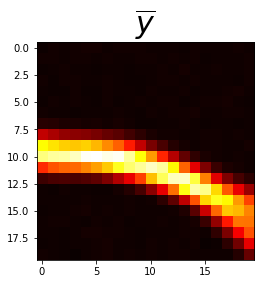

In [14]:
# Load stack
stream = io.imread('datasets/sofi_filaments/tubulin_noiseless_highBg.tif')
pile = torch.from_numpy(np.array(stream, dtype='float64')) [:,15:35,40:60]
pile_max = torch.max(pile)
pile /= pile_max
pile += torch.normal(0, 5e-2, size=pile.shape)

plt.figure()
plt.imshow(pile.mean(0), cmap='hot')
plt.title('$\overline{y}$', fontsize=30)
plt.colorbar()
plt.show()

Compute cumulants, for instance $R_y$ with `covariance_pile`.

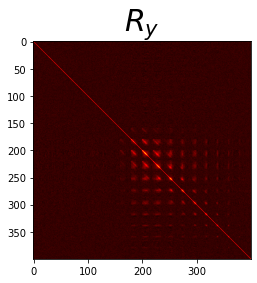

In [15]:
# Compute cumulants
y_bar_cpu = torch.mean(pile.float(), 0)
y_bar = (y_bar_cpu).to(device)
R_y = cudavenant.covariance_pile(pile).to(device)


N_ECH = y_bar.shape[0]
X_GAUCHE = 0
X_DROIT = 1
FWMH = 2.2875 / N_ECH
SIGMA = FWMH / (2 * np.sqrt(2*np.log(2)))
domain = cudavenant.Domain2D(X_GAUCHE, X_DROIT, N_ECH, SIGMA, dev=device)
domain_cpu = cudavenant.Domain2D(X_GAUCHE, X_DROIT, N_ECH, SIGMA)

q = 2**3
super_domain = domain.super_resolve(q, SIGMA/4)

plt.imshow(R_y.to('cpu'), cmap='hot')
plt.title('$R_y$', fontsize=30)
plt.colorbar()
plt.show()

Solve $(\mathcal{Q}_\lambda(y))$ and $(\mathcal{P}_\lambda(\overline y))$ with Sliding Frank-Wolfe:

In [16]:
lambda_cov = 1e-6
lambda_moy = 1e-3
iteration = 25 # this is just for the desmontration, in general one rather sets 100

(m_cov, nrj_cov, mes_cov) = cudavenant.SFW(R_y, domain, regul=lambda_cov,
                                           nIter=iteration, mesParIter=True,
                                           obj='covar', printInline=False)

(m_moy, nrj_moy, mes_moy) = cudavenant.SFW(y_bar - y_bar.min(), domain,
                                           regul=lambda_moy,
                                           nIter=iteration, mesParIter=True,
                                           obj='acquis', printInline=False)

print(f'm_cov : {m_cov.N} Diracs')
print(f'm_moy : {m_moy.N} Diracs')

m_cov : 25 Diracs
m_moy : 25 Diracs


Plot the results and save if needed (`__saveFig__ = False` is this tutorial)

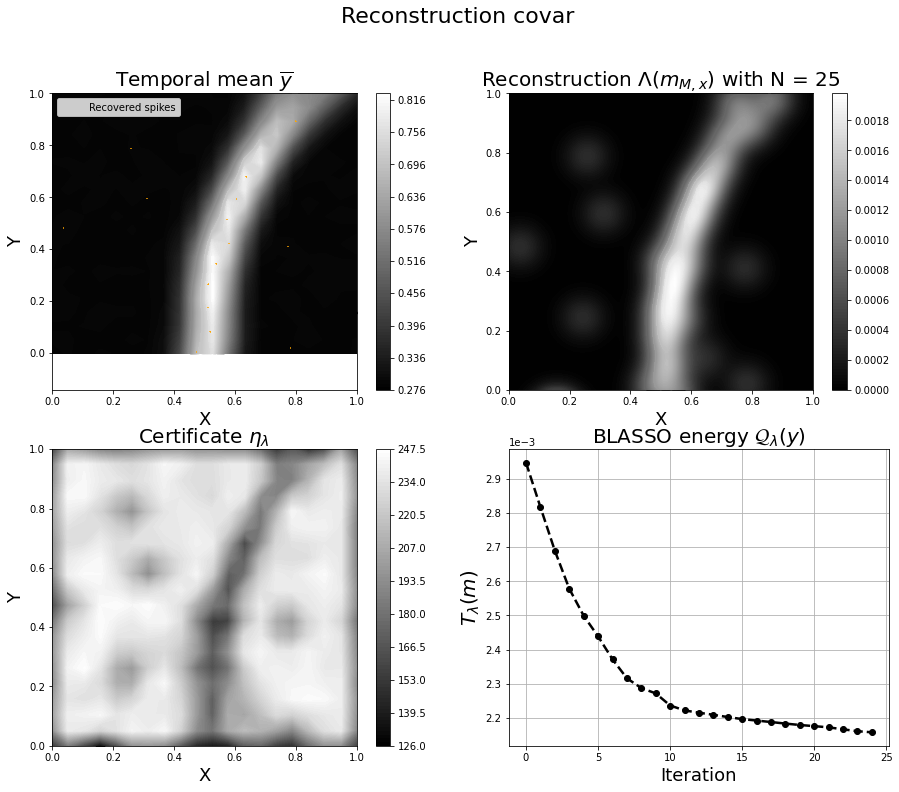

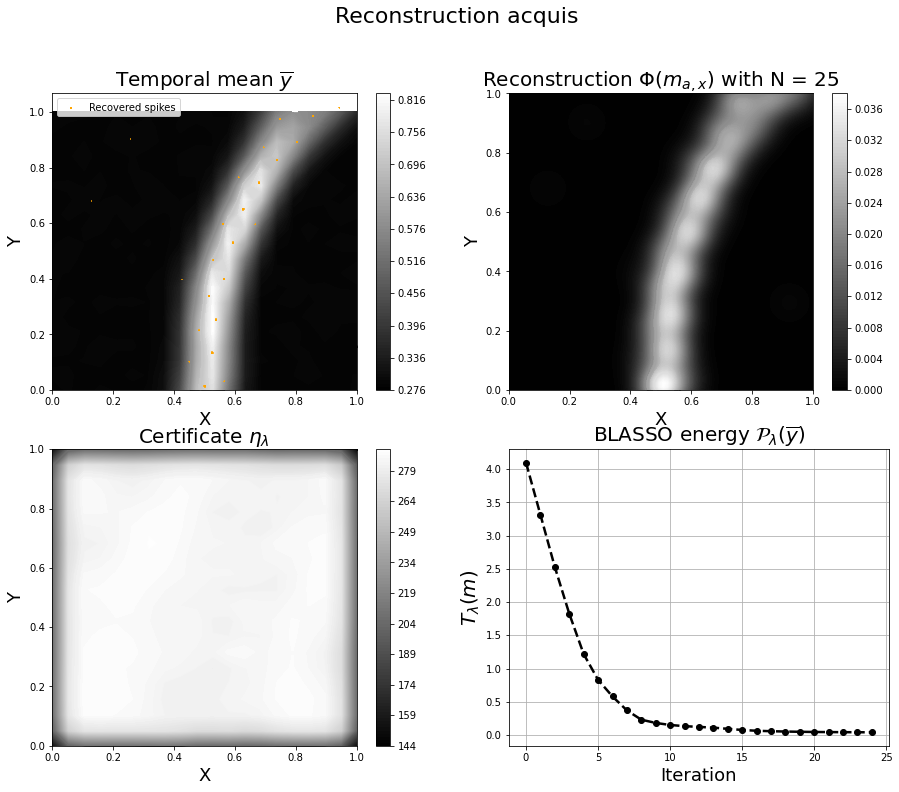

In [17]:
if m_cov.N > 0:
    certificat_V_cov = cudavenant.etak(m_cov, R_y, domain, lambda_cov,
                                       obj='covar').to('cpu')
    m_cov_cpu = m_cov.to('cpu')
    cudavenant.plot_experimental(m_cov_cpu, domain_cpu, y_bar_cpu , 
                                 nrj_cov[:123],
                                 certificat_V_cov, 
                                 obj='covar',
                                 saveFig=__saveFig__, 
                                 title='filaments-covar-global')
if m_moy.N > 0:
    certificat_V_moy = cudavenant.etak(m_moy, y_bar, domain, lambda_moy,
                                       obj='acquis').to('cpu')
    m_moy_cpu = m_moy.to('cpu')
    cudavenant.plot_experimental(m_moy_cpu, domain_cpu, y_bar_cpu, nrj_moy,
                                 certificat_V_moy, 
                                 obj='acquis',
                                 saveFig=__saveFig__, 
                                 title='filaments-moy-global')


Thus concluding this part of the tutorial handling the fixed spikes reconstruction.

## 3. Off-the-grid curve reconstruction: AMG ongoing work 🚧

### Check the  [associated theoretical paper](https://hal.archives-ouvertes.fr/hal-03658949)

Consider the following Banach space:

$$ \mathscr{V} = \left\{ m \in \mathcal{M(X)}^2, \, \mathrm{div}(m) \in \mathcal{M(X)} \right\}$$

where $\mathrm{div}$ ought to be understood in the sense of distribution.
Let us introduce the curve functional called CROC, standing for *Curves Represented On Charges*:

$$ \mathrm{argmin}_{m \in \mathscr{V}} || y - \Phi m ||_\mathcal{H}^2 + \alpha ||m||_{\mathscr{V}} \quad\quad\quad (\mathcal{Q}_\alpha(y))$$ 

Through a method we coined [AMG (*Atomic based Method for Gridless*)](https://hal.archives-ouvertes.fr/hal-03658949), we proved that extremal points of the $\mathscr V$-norm unit ball are measures supported on curves. Hence, the Sliding Frank-Wolfe can reconstruct curves.

In [18]:
# import curvenant

We are still working on it 😵‍

 ## 4. Dynamic Dirac reconstruction: forthcoming work 🚧

We are still working on it 😵‍